# Initial Planning

****
## Background
****

* Location: Kibutz Dafna
* Field area: 20137 m$^2$
* Soil: brown Rendzina
* Crop: Avocado

****
## Map
****

We used the [GovMap]([https://www.govmap.gov.il/) website with the [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/) in order to get the coordinate data of our plot which is according to this plot:

In [27]:
# Importing
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
sns.set_context("paper",font_scale=2)

from scipy.interpolate import griddata

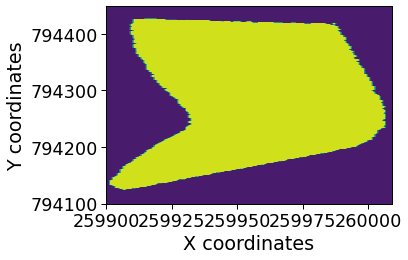

In [28]:
plt.figure()
x = np.load('CoordinatesData/x.npy')
y = np.load('CoordinatesData/y.npy')
z = np.load('CoordinatesData/z.npy')
plt.contourf(x, y, z)
plt.ticklabel_format(useOffset=False)
plt.xlabel('X coordinates')
plt.ylabel('Y coordinates')
plt.tight_layout()

out_of_bound_i = np.argwhere(z == 0)

Then from the contour lines of altitude in the original map we sample points of 160, 165, 170 and 175 to interpolate all of the coordinate values. The interpolation method is piecewise cubic, continuously differentiable (more details [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CloughTocher2DInterpolator.html#scipy.interpolate.CloughTocher2DInterpolator)).

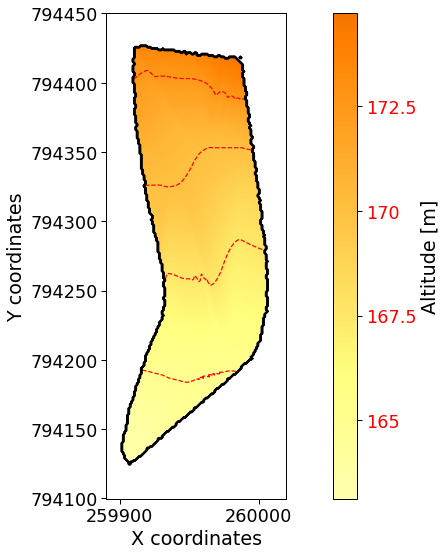

In [29]:
# Aranging the observed data for interpolation
valued_z = []
valued_xy = []
for contour_value in [160,165,170,175]:
    data = pd.read_csv('AltitudeData/{}contour.csv'.format(contour_value))
    for instance in data.values:
        valued_xy.append(instance)
        valued_z.append(contour_value)
valued_z = np.array(valued_z)
valued_xy = np.array(valued_xy)


# Plotting + Interpolation
fig, axis = plt.subplots(figsize=(15,8))
xy = np.c_[x.flatten(),y.flatten()]
altitude = griddata(valued_xy, valued_z, xy, 'cubic').reshape(z.shape) # Interpolation
altitude[out_of_bound_i[:,0],out_of_bound_i[:,1]] = np.nan
cs_contourf = plt.contourf(x,y,altitude,1000, cmap='afmhot_r',vmin=158,vmax=190)
clabel = plt.contour(x,y,altitude,[165,167.5,170,172.5],
                     colors='red',
                     linestyles='dashed')
plt.ticklabel_format(useOffset=False)

cbar = fig.colorbar(cs_contourf, ticks=[165, 167.5, 170, 172.5])
cbar.ax.set_yticklabels([165, 167.5, 170, 172.5], color='red')
cbar.set_label('Altitude [m]')

plt.contour(x, y, z,colors='black', linewidths =1.5)
plt.xlabel('X coordinates')
plt.ylabel('Y coordinates')
plt.tight_layout()
axis.set_aspect('equal', 'box')
plt.ylim(794100, 794450)
plt.xlim(259890, 260020)
plt.xticks(ticks=[259900,260000], labels=[259900,260000])
plt.savefig('Figures/map.png',bbox_inches='tight')

And in 3D:

C:\Users\User8\AppData\Local\Temp/ipykernel_16900/2272324159.py:5: UserWarning: The following kwargs were not used by contour: 'ls'
  axis.contour(x,y,altitude,np.arange(np.nanmin(altitude), np.nanmax(altitude),1),


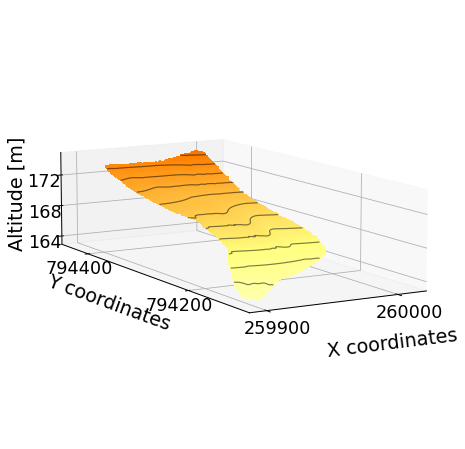

In [30]:
from mpl_toolkits.mplot3d import Axes3D
fig, axis = plt.subplots(subplot_kw={"projection": "3d"},figsize = (15,8))
axis.contourf(x,y,altitude, 1000, cmap='afmhot_r',vmin=158,vmax=190)
axis.set_zlim(np.nanmin(altitude), np.nanmax(altitude))
axis.contour(x,y,altitude,np.arange(np.nanmin(altitude), np.nanmax(altitude),1),
                     colors='k', ls='--', alpha=0.5)
axis.set_box_aspect((1,2,0.5))
axis.set_ylim(794100, 794450)
axis.set_xlim(259890, 260020)
plt.xticks(ticks=[259900,260000], labels=[259900,260000])
plt.yticks(ticks=[794200,794400], labels=[794200,794400])
axis.set_zticks([164,168,172])
axis.set_xlabel('X coordinates', labelpad=30)
axis.set_ylabel('Y coordinates', labelpad=30)
axis.zaxis.set_rotate_label(False)  # disable automatic rotation
axis.set_zlabel('Altitude [m]', rotation=90 ,labelpad=10)
axis.view_init(10, -120)
plt.savefig('Figures/3d_map.png',bbox_inches='tight')

Let's check the statistical properties of the topography:

In [31]:
print('Min={:.0f}m, Max={:.0f}m, Mean={:.0f}m'.format(np.nanmin(altitude),
                                          np.nanmax(altitude),
                                          np.nanmean(altitude)))

Min=163m, Max=175m, Mean=168m


****
## Plant Demand
****

In order to calculate plant demand we used $ET_c = K_c \times ET_0$. 

From the IMS $ET_0$ was obtained. We assumed that each 10$^\text{th}$ group inside a specific month share the same monthly $ET_0$

In [32]:
ET0 = np.array([1.4, 2.0, 3.2, 4.2, 5.8, 6.8, 6.7, 6.2, 5.2, 3.5, 2.1, 1.3])
ET0 = np.array([[e,e,e] for e in ET0]).flatten()

From  [University of California Division of Agriculture and Natural Resources](http://ucavo.ucr.edu/Irrigation/CropCoefficients.html) $K_c$ was obtained. However, it's only monthly values as well. Let's plot it

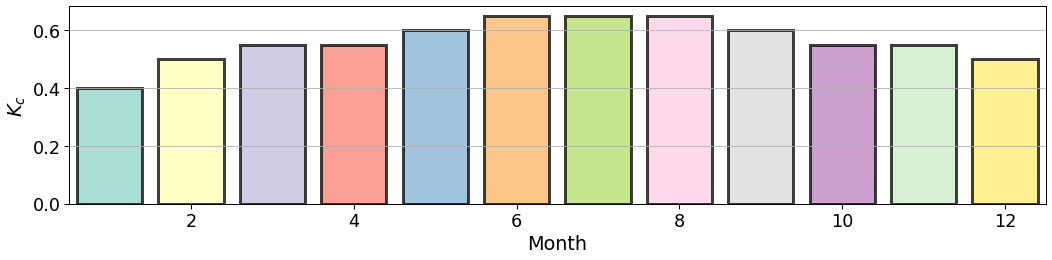

In [33]:
COLORS = plt.cm.Set3(np.linspace(0, 1, 12))  # 12 RGB instances for 12 months colors

Kc = np.array([0.4, 0.5, 0.55, 0.55, 0.6, 0.65, 0.65, 0.65, 0.6, 0.55, 0.55, 0.5])
t = np.arange(1,13,1)
fig = plt.figure(figsize=(15,4))
plt.bar(t, Kc, edgecolor='black', lw=3, color=COLORS[t-1], alpha=0.75)
plt.grid(axis='y')
plt.xlabel('Month')
plt.ylabel(r'$K_c$')
plt.xlim(0.5,12.5)
plt.tight_layout()

## Introducing 10$^\text{th}$ Day Group Dynamic $K_c$ According to FAO

We would like to consider 10$^\text{th}$-day dynamic $K_c$ and not month-scale dynamic $K_c$.

According to [FAO](https://www.fao.org/3/x0490e/x0490e0b.htm), the trends in $K_c$ during the growing period are represented in the crop coefficient curve which requires $K_c$ in three different development stages which are:

* $K_c$ during the initial stage (Kc ini) = $\color{red}{0.6}$
* $K_c$ during the mid-season stage (Kc mid)= $\color{red}{0.85}$
* $K_c$ at the end of the late season stage (Kc end) = $\color{red}{0.75}$

Now we need to construct the curve according to 4 stages:
* initial, where $K_c$ is the value as it's during the initial stage. The duration of this stage is estimated according to the last graph of $K_c$ and we assumed it's from begining of January (1) till the end of it.
* crop development, where $K_c$ lineary increases from initial value to the mid value. We assumed that it's from the begining of February (2) until end of May (5)
* mid-season, where $K_c$ is the value as it's during mid-stage. Estimated from the begining of June (6) until the end of September (9)
* late season stage, where $K_c$ lineary decreases from the mid-value to end-value. We assmued it's from the end of September (9) until the end of December (12).

$\displaystyle K_c = 
\begin{cases}
  0.6  & 1 \le t < 4  \\
  0.01923t+0.5423  & 4 \le t < 16  \\
  0.85  & 16 \le t < 28  \\
  -0.011 t + 1.15 & 28 \le t \le 36  \\
\end{cases}$

Where $t = \text{10 days group of } \{1,2,3,...,36\}$

According to this information we construct a 10$^\text{th}$-day dynamic $K_c$

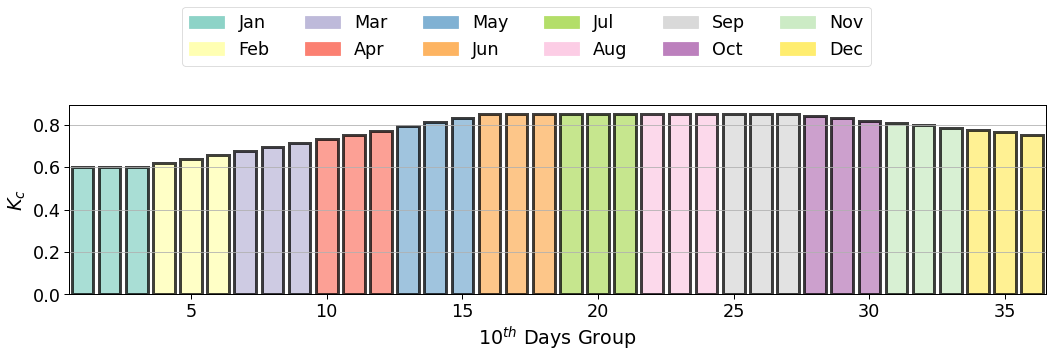

In [34]:
t = np.arange(1,37,1)
Kc = np.zeros(t.shape)
Kc = np.where(t > 0, 0.6 , Kc)
Kc = np.where(t > 3, 0.01923 * t + 0.5423, Kc)
Kc = np.where(t >= 16, 0.85 , Kc)
Kc = np.where(t > 27, -0.011 * t + 1.15 , Kc)

color_indices = np.array([[i,i,i] for i in range(0,12)]).flatten()

fig = plt.figure(figsize=(15,4))
plt.bar(t, Kc, edgecolor='black', lw=3, color=COLORS[color_indices], alpha=0.75)
plt.grid(axis='y')
plt.xlabel(r'10$^{th}$ Days Group')
plt.ylabel(r'$K_c$')
plt.xlim(0.5,36.5)

# Adding legend by creating patches without plotting them
handles = []
Months_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for m in range(1,13): # For every month
    patch = mpatches.Patch(color=COLORS[m-1], label=Months_names[m-1])
    handles.append(patch)
fig.legend(handles=handles, ncol=6, loc=9, bbox_to_anchor=(0.5,1.3))
plt.tight_layout()
plt.savefig('Figures/kc.png',bbox_inches='tight')

In [35]:
# Exporting Kc to excel
df = np.c_[(color_indices + 1).reshape(-1,1),np.array([[1,2,3] for _ in range(12)]).flatten().reshape(-1,1),Kc.reshape(-1,1)]
df = pd.DataFrame(df, columns=['Month','Tenth','Kc'])
#df.to_excel('Kc.xlsx')

According to that, we construct our new **monthly** Kc as the monthly mean of $K_c$. We use this one to calculate ETc for our initial planning and the water board.

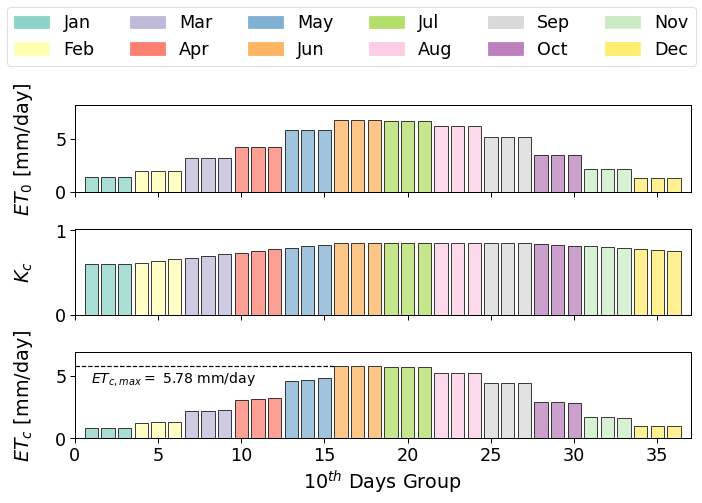

In [36]:
def plot_series1(axis, s):
    t = np.arange(1,37,1)
    label = s.name
    color_indices = np.array([[i,i,i] for i in range(0,12)]).flatten()
    axis.bar(t,
            s.values,
            color=COLORS[color_indices],
            edgecolor='black',
            lw=1,
             alpha=0.75)
    axis.grid(b=False)
    axis.set_ylabel(label, labelpad=20)
    axis.set_ylim(0,max(s.values)*1.2)

ETc = Kc * ET0
plant_demand = pd.DataFrame()
plant_demand[r'$ET_0 $ [mm/day]'] =ET0
plant_demand[r'$K_c$'] = Kc
plant_demand[r'$ET_c $ [mm/day]'] = ETc

fig, axes = plt.subplots(3,1,sharex=True,figsize=(10,6))
for i, col_name in zip(range(len(axes)), plant_demand):
    plot_series1(axes[i], plant_demand[col_name])

axes[-1].set_xlim(0,37)
axes[-1].hlines(np.max(ETc),0,15.6,color='k',ls='--')  
axes[-1].text(1,4.5,r'$ET_{c,max} =$'+' {:.3} mm/day'.format(np.max(ETc)),fontsize=14)
axes[-1].set_xlabel(r'10$^{th}$ Days Group')

# Adding legend by creating patches without plotting them
handles = []
Months_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for m in range(1,13): # For every month
    patch = mpatches.Patch(color=COLORS[m-1], label=Months_names[m-1])
    handles.append(patch)
fig.legend(handles=handles, ncol=6, loc=9, bbox_to_anchor=(0.5,1.2))
plt.tight_layout()
plt.savefig('Figures/plant_demand_FAO.png',bbox_inches='tight')

And let's save this data as excel:

In [50]:
plant_demand.to_excel('Plant_Demand.xlsx')

****
## Effective Rain
****

Raw monthly rainfall data was downloaded from the [IMS website](https://ims.gov.il/he) using station number 310093 for monthes october 2011 until october 2021.

In [38]:
data = pd.read_csv('RainData/Dafna_monthly_rain_11-21.csv')
data

,station_num,Date,Rainfall,Rain code
0,310093,10-2011,1.4,0
1,310093,11-2011,121.2,0
2,310093,12-2011,33.2,0
3,310093,01-2012,257.2,0
4,310093,02-2012,160.3,0
...,...,...,...,...
99,310093,03-2021,36.2,0
100,310093,04-2021,16.0,0
101,310093,05-2021,0.0,0
102,310093,08-2021,0.0,0


The next cell deletes redundant columns, changing the columns name and seperate the year from the month:



In [39]:
data = data.iloc[:,1:3] # Deleting redundant columns
data.columns = ['Time', 'Rainfall [mm/month]']
data['Month'] = data['Time'].apply(lambda time: time.split('-')[0])
data['Year'] = data['Time'].apply(lambda time: time.split('-')[1])
data.drop(['Time'], inplace=True, axis=1) # Deleting redundant columns
data

,Rainfall [mm/month],Month,Year
0,1.4,10,2011
1,121.2,11,2011
2,33.2,12,2011
3,257.2,01,2012
4,160.3,02,2012
...,...,...,...
99,36.2,03,2021
100,16.0,04,2021
101,0.0,05,2021
102,0.0,08,2021


The next cell plot all of the data:

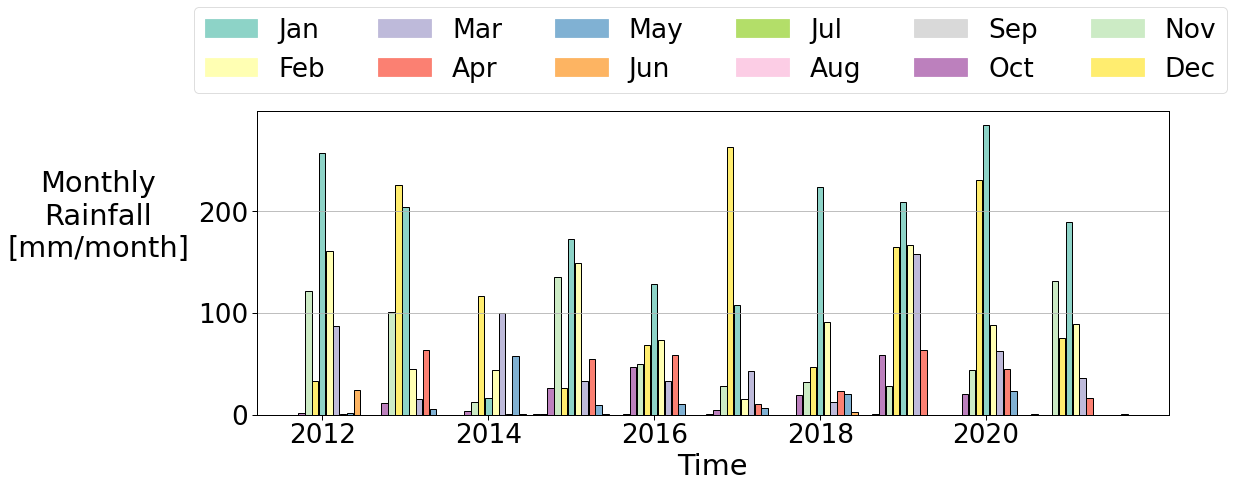

In [40]:
# Creating the Timestamp column
data['Timestamp'] = data[['Year','Month']].apply(lambda x: pd.Timestamp(x[0]+'-'+x[1]+'-01T12'), axis=1)

sns.set_context("paper",font_scale=3)
fig = plt.figure(figsize=(17,6))

bar_width = pd.Timedelta(days=28)
color_indices = data['Timestamp'].apply(lambda x: x.month) - 1 # Indices to choose from colors

plt.bar(data['Timestamp'],
        data['Rainfall [mm/month]'],
        width=bar_width,
        color=COLORS[color_indices],
        edgecolor='black',
        lw=1)
plt.grid(axis='y')
plt.xticks(ticks=[pd.Timestamp(str(year)+'-01-01T12') for year in [2012,2014,2016,2018,2020]],
           labels=[2012,2014,2016,2018,2020])

# Adding legend by creating patches without plotting them
handles = []
Months_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for m in range(1,13): # For every month
    patch = mpatches.Patch(color=COLORS[m-1], label=Months_names[m-1])
    handles.append(patch)
fig.legend(handles=handles, ncol=6, loc=9, bbox_to_anchor=(0.6,1.2))

plt.xlabel('Time')
plt.ylabel('Monthly\nRainfall\n[mm/month]', rotation=0,labelpad=100)
plt.tight_layout()
plt.savefig('Figures/10Years_rain_data.png',bbox_inches='tight')

Calculating: 
* Mean monthly rainfall
* Std of the monthly rainfall
* 80% Dependable Rain according to: Mean - 0.84 $\times$ Std

In [41]:
month_values = np.array(data['Month'], dtype=int) # All data monthes values as integers
month_rain_mean = np.array([])
month_rain_std = np.array([])

for m in range(1,13): # Per each month calculating the mean and std
    i = np.where(month_values == m)
    mean = np.mean(data['Rainfall [mm/month]'].values[i])
    std = np.std(data['Rainfall [mm/month]'].values[i])
    month_rain_mean = np.append(month_rain_mean, mean)
    month_rain_std = np.append(month_rain_std, std)

# Getting rid of nan values where monthes are dry
month_rain_mean = np.where(np.isnan(month_rain_mean), 0, month_rain_mean)
month_rain_std = np.where(np.isnan(month_rain_std), 0, month_rain_std)

# calculating 80% dependable rainfall
dep_rain_80 = month_rain_mean - 0.84 * month_rain_std

rain_data = pd.DataFrame(np.c_[month_rain_mean, month_rain_std, dep_rain_80],
                         index=range(1,13),
                         columns=['Monthly Rain Mean [mm/month]',
                                  'Monthly Rain Std [mm/month]',
                                  '80% Dependable Rain [mm/month]'])
rain_data.index.name = 'Month'
rain_data

C:\Users\User8\anaconda3\envs\Env_2\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User8\anaconda3\envs\Env_2\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\User8\anaconda3\envs\Env_2\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\User8\anaconda3\envs\Env_2\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\User8\anaconda3\envs\Env_2\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Monthly Rain Mean [mm/month],Monthly Rain Std [mm/month],80% Dependable Rain [mm/month]
Month,,,
1,179.130000,74.122615,116.867003
2,92.070000,49.357270,50.609893
3,57.750000,42.919232,21.697845
4,33.480000,24.784261,12.661221
5,13.410000,16.514142,-0.461880
6,5.500000,9.198478,-2.226722
7,0.000000,0.000000,0.000000
8,0.122222,0.257241,-0.093860
9,0.160000,0.237487,-0.039489


Let's plot 80% Dependable Rain (considering negative values as 0 mm):

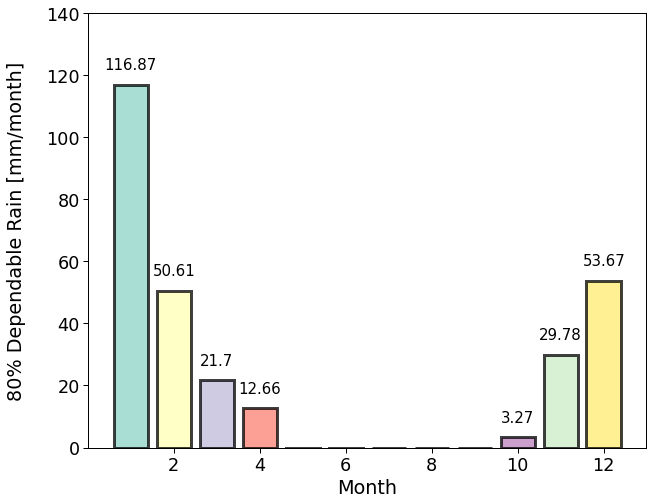

In [42]:
sns.set_context("paper",font_scale=2)
fig, axis = plt.subplots(figsize=(10,8))
s = rain_data['80% Dependable Rain [mm/month]']
label = s.name
color_indices = s.index - 1  # Indices to choose from colors - by month number
axis.bar(s.index,
        s.values,
        color=COLORS[color_indices],
        edgecolor='black',
        lw=3,
         alpha=0.75)
axis.grid(axis='y')
axis.set_ylabel(label, labelpad=20)
axis.set_ylim(0,max(s.values)*1.2)
# Plotting values
for index, value in zip(s.index, s.values):
    if value  > 0:
        axis.text(index, value+5, str(round(value, 2)), ha='center', fontsize=15)

axis.set_xlabel('Month')
plt.grid(axis='y')
plt.savefig('Figures/dependable_rain.png')

As you can see, during June (where $ET_c$ is maximum) the 80% dependable rain is zero, so there is no need to consider rain at that time.

And the next code is for visualizing all of the raw data of monthly rain that we used for this calculation:

****
## Maximum Irrigation Demand
****

According to:

$\displaystyle IR_n = ET_c - (Pe + Ge + Wb) + LR_{mm}$

$\displaystyle IR_b = \frac{IR_n}{E}$

In the maximum state, we use values of:
* Maximum $ET_c=5.78$ mm/day
* Corresponding effective rainfall $Pe=0$ mm/day. Due to 80% Dependable Rain = 0.
* No salts washing
* $Ge, Wb \approx 0$ mm/day
* Assuming $E\approx90 \%$ according to the fact that we use localized irrigation system.

In [43]:
IRn = max(ETc) 
IRb = IRn / 0.9
IRb

6.422222222222222

$IR_b = 6.42$ mm/day.

****
## $d_x$ Calculation
****

In soil testing course, a relative similar soil to our was measured (Randazina from Ravid). Some of the measurements are:

* Field Capacity: 0.376 $\frac{g_\text{water}}{g_\text{soil}}$
* Permanent Wilting Point: 0.102 $\frac{g_\text{water}}{g_\text{soil}}$
* Bulk Density: $D_b$ = 1.15

So in order to get the volumetric water content we need to use:

$\displaystyle \theta_v =D_b \times \frac{\theta_w}{D_\text{water}} $

In [44]:
Db = 1.15
FC_w = 0.376 # [-] Field Capacity - weight fraction
PWP_w = 0.102 # [-] Permanent Wilting Point - weight fraction

FC = Db * FC_w # [-] Field Capacity - volumetric fraction
PWP = Db * PWP_w # [-] Permanent Wilting Point - volumetric fraction

(FC, PWP)

(0.43239999999999995, 0.11729999999999999)

In [45]:
TAM = (FC - PWP) * 1e3 # from [m/m] to [mm/m]
TAM 

315.0999999999999

* Field Capacity: **$\color{red}{\text{FC = 432 mm/m}}$**
* Permanent Wilting Point: **$\color{red}{\text{PWP = 117 mm/m}}$**

So:
* Total Available Moisture: **$\color{red}{\text{TAM = 315 mm/m}}$**.
* Accoding to [Bender and Faber](https://ucanr.edu/sites/alternativefruits/files/166631.pdf), MAD = 30-50%. However, it's recommended to use 50% for heavy soils. So **$\color{red}{\text{MAD = 50%}}$**.
* According to ([Salgado and Cautin, 2008](https://www.sciencedirect.com/science/article/pii/S0378377408000516?casa_token=uqF60wXjMw8AAAAA:olQdXg7JNnKy8DoC9ARB5q-cBPuzWPwXzG93-os0vRD2fnoMY0g79aNHI64DTB88NeMyySr1)), Z=0.3-0.6 m. So **$\color{red}{\text{Z = 0.5 m}}$**.

In adidition, we need to consdier $P_w$ according to:

$\displaystyle P_w = 
\begin{cases}
  100 \frac{N_pS_ew}{S_pS_r} & \text{if} &  S_e < 0.8w  \\
  100 \frac{0.8N_pw^2}{S_pS_r} & \text{if} & S_e \ge 0.8w
\end{cases}$

According to the [FAO](https://www.fao.org/3/ai598e/ai598e.pdf), in the absence of locally available data on the wetted patterns of one emmiter, we can use the area wetted by one emitter as depending on soil type according to:

| Soil Type | Area wetted by one emitter (m$^2$) |
|-----------|------------------------------------|
| Sandy     | 0.5-2                              |
| Loam      | 2-6                                |
| Clay      | 6-15                               |

We consider our soil as clay  A$_\text{wet}$ = 6 - 15 m$^2$. The diameter of the area is:

D$=\sqrt{4\times\text{A}_\text{wet}/\pi}=2.76 - 4.71$ m. We will take value of 3 m $\rightarrow$ **$\color{red}{w = 3 \text{m}}$**

According to locally available data:
* The usually space between emitters: $\color{red}{S_e = 0.4 \text{m}}$.
* The space between trees and rows is $\color{red}{S_p=3\text{m}}$ and $\color{red}{S_r=6\text{m}}$ respectively.
* The number of emitters per tree depends on the development stage. According to ([Salgado and Cautin, 2008](https://www.sciencedirect.com/science/article/pii/S0378377408000516?casa_token=uqF60wXjMw8AAAAA:olQdXg7JNnKy8DoC9ARB5q-cBPuzWPwXzG93-os0vRD2fnoMY0g79aNHI64DTB88NeMyySr1)), roots distribution is pretty wide, we'll take $\color{red}{N_p=5\text{m}}$ as an average.

In [46]:
w = 3
Se = 0.4
Sp = 3
Sr = 6
Np = 5

Pw = 100 * (Np * Se * w) / (Sp * Sr)
Pw

33.333333333333336

So we use 33.33% as the value of the wet area in the field.

According to:

$\displaystyle d_x = \text{MAD}\times\text{TAM}\times\text{Z}\times\frac{P_w}{100}$

In [47]:
MAD = 0.5 # [-]
Z = 0.5 # [m]
dx = MAD * TAM * Z * Pw / 100
dx # [mm]

26.258333333333326

$\color{red}{d_x=\text{26.26 mm}}$.

We can calculate now the flow per irrigation by:

$\displaystyle Q = d_x \times A$

In [48]:
A = 20137 # [m^2]
Q = dx * 1e-3 * A # [m^3/irr]
Q

528.7640583333332

$\color{red}{Q = 528.76\text{ m}^3/\text{irrigation}}$

The irrigation frequency is calculated by:

$\displaystyle f_x = \frac{d_x}{IR_b}$

In [49]:
fx = dx / IRb
fx

4.088667820069204

$f_x \approx 4 \text{ days}$

So we going to reduce 3  to get a frequency of $\color{red}{1 \text{ day}}$

# NOTE

For the next notebooks, we save all of the necessary functions in Functions.py so we won't have to write all of the code one again.